In [4]:
import torch

# 检查是否有可用的GPU
print(torch.cuda.is_available())

# 输出当前使用的GPU设备
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available.")

import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import Dataset, DataLoader

# 加载Financial PhraseBank数据集
file_path = 'E:/Haibo_Fang23-24-Dissertation/report/FinancialPhraseBank-v1.0/Sentences_50Agree.txt'

# 加载数据并添加列名
df = pd.read_csv(file_path, delimiter='@', header=None, names=['sentence', 'sentiment'], encoding='ISO-8859-1')

# 去除空白符号
df['sentence'] = df['sentence'].str.strip()
df['sentiment'] = df['sentiment'].str.strip()

# 将情绪标签转换为数字
df['sentiment'] = df['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

# 划分训练集和测试集
train_texts, test_texts, train_labels, test_labels = train_test_split(df['sentence'].tolist(), df['sentiment'].tolist(), test_size=0.2, random_state=42)

# 自定义数据集类
class FinancialPhraseBankDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 加载预训练的BERT模型和tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name).to(device)

# 创建数据集和数据加载器
train_dataset = FinancialPhraseBankDataset(train_texts, train_labels, tokenizer, max_len=512)
test_dataset = FinancialPhraseBankDataset(test_texts, test_labels, tokenizer, max_len=512)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


True
0
NVIDIA GeForce RTX 2060
Using device: cuda


In [5]:
import torch.nn as nn

class BertLSTMModel(nn.Module):
    def __init__(self, bert_model, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(BertLSTMModel, self).__init__()
        self.bert = bert_model
        self.lstm = nn.LSTM(bert_model.config.hidden_size, 
                            hidden_dim, 
                            num_layers=n_layers, 
                            bidirectional=bidirectional, 
                            batch_first=True, 
                            dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            embedded = self.bert(input_ids, attention_mask=attention_mask)[0]
        lstm_out, (hidden, cell) = self.lstm(embedded)
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        output = self.fc(hidden)
        return output

# 定义模型
hidden_dim = 256
output_dim = 3
n_layers = 2
bidirectional = True
dropout = 0.3

model = BertLSTMModel(bert_model, hidden_dim, output_dim, n_layers, bidirectional, dropout).to(device)

import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 定义优化器和损失函数
optimizer = optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss().to(device)

# 训练函数
def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# 评估函数
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1).flatten()
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return total_loss / len(dataloader), predictions, true_labels


In [6]:
import optuna

n_epochs = 3  # 定义训练的轮数

def objective(trial):
    # 定义超参数
    hidden_dim = trial.suggest_int('hidden_dim', 128, 512)
    n_layers = trial.suggest_int('n_layers', 1, 3)
    bidirectional = trial.suggest_categorical('bidirectional', [True, False])
    dropout = trial.suggest_uniform('dropout', 0.1, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-4)
    
    model = BertLSTMModel(bert_model, hidden_dim, output_dim, n_layers, bidirectional, dropout).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # 训练和评估模型
    for epoch in range(n_epochs):
        train_loss = train_model(model, train_loader, optimizer, criterion, device)
        valid_loss, predictions, true_labels = evaluate_model(model, test_loader, criterion, device)
        accuracy = accuracy_score(true_labels, predictions)
    
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

best_params = study.best_params
print("Best parameters:", best_params)

# 使用最佳超参数重新训练模型
model = BertLSTMModel(bert_model, best_params['hidden_dim'], output_dim, best_params['n_layers'], 
                      best_params['bidirectional'], best_params['dropout']).to(device)
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])

# 训练和评估
for epoch in range(n_epochs):
    train_loss = train_model(model, train_loader, optimizer, criterion, device)
    valid_loss, predictions, true_labels = evaluate_model(model, test_loader, criterion, device)
    accuracy = accuracy_score(true_labels, predictions)
    print(f'Epoch {epoch+1}/{n_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Accuracy: {accuracy:.4f}')

# 打印分类报告
print(classification_report(true_labels, predictions, target_names=['negative', 'neutral', 'positive']))


[I 2024-06-25 16:54:49,598] A new study created in memory with name: no-name-70c223ca-a5e1-442c-893e-116298c749de
C:\Users\48869\AppData\Local\Temp\ipykernel_3332\2462094241.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)
C:\Users\48869\AppData\Local\Temp\ipykernel_3332\2462094241.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-4)
c:\Users\48869\anaconda3\envs\new_env\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0

Best parameters: {'hidden_dim': 413, 'n_layers': 2, 'bidirectional': True, 'dropout': 0.38384259206641963, 'learning_rate': 4.042723942202167e-05}
Epoch 1/3
Train Loss: 0.7674, Valid Loss: 0.5746, Accuracy: 0.7320
Epoch 2/3
Train Loss: 0.5498, Valid Loss: 0.5328, Accuracy: 0.7660
Epoch 3/3
Train Loss: 0.4802, Valid Loss: 0.5025, Accuracy: 0.7660
              precision    recall  f1-score   support

    negative       0.68      0.57      0.62       110
     neutral       0.86      0.81      0.83       571
    positive       0.64      0.75      0.69       289

    accuracy                           0.77       970
   macro avg       0.73      0.71      0.72       970
weighted avg       0.77      0.77      0.77       970



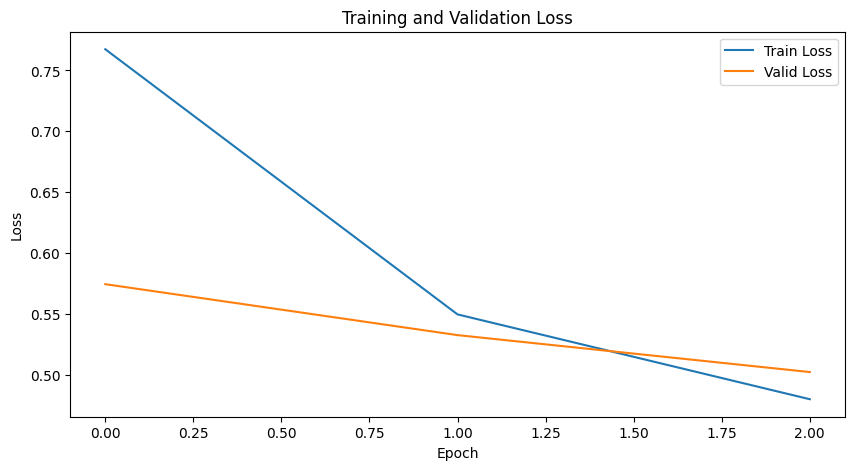

In [9]:
import matplotlib.pyplot as plt

# 假设这些是你已经记录好的损失数据
train_losses = [0.7674, 0.5498, 0.4802]  # 替换为你的实际训练损失数据
valid_losses = [0.5746, 0.5328, 0.5025]  # 替换为你的实际验证损失数据

# 绘制损失曲线
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()
